# [Advent of Code 2019](http://adventofcode.com/2019)


Jim Mahoney | jimmahoney@bennington.edu | cs.bennington.college

## Preparations

In [1]:
# Some of these are from Peter Norvig's 
# github.com/norvig/pytudes/blob/master/ipynb/Advent%202017.ipynb

import numpy as np
from numpy import sin, cos, sqrt, pi
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from statistics import mean, median, stdev
from IPython.core.display import HTML
import subprocess

# Download puzzle input files into e.g. puzzle_input/1.txt .
def puzzle_input(daynumber):
    """ return the open file for given day """
    filename = f"puzzle_inputs/{daynumber}.txt"
    try:
        return open(filename)
    except FileNotFoundError:
        print(f"Oops - couldn't find '{filename}'")

# -- 2D points with vector operations  --

#    Using tuples rather than numpy arrays or complex numbers
#    keeps integers as integers so grids work without roundoff errors.
def point(x, y): return (x, y)
def X(p): return p[0]
def Y(p): return p[1]
def dot(p1, p2): return X(p1)*X(p2) + Y(p1)*Y(p2)
def length(p):return sqrt(dot(p, p))
def manhattan(p): return abs(X(p)) + abs(Y(p))
def add(p1, p2): return point(X(p1) + X(p2), Y(p1) + Y(p2))
def scale(s, p): return point(s * X(p), s * Y(p))
#    examples :
assert X(point(3,4))==3 and Y(point(3,4))==4
assert add(point(1,2), point(3,4)) == point(4,6)
assert dot(point(1,2), point(10,11)) == 32
assert scale(2, point(3,4)) == point(6,8)
assert length(point(3,4)) == 5
assert manhattan(point(3,-5)) == 8

# -- functional utilities

def allsame(xs): return len(set(xs))==1
def allunique(xs): return len(set(xs))==len(xs)
def length(xs): return len(tuple(xs)) # works on filter,map,...
identity = lambda x:x
def first(xs, default=None): 
    try:
        return (tuple(xs))[0]
    except:
        return default
def nth(xs, n, default=None): 
    try:
        return (tuple(xs))[n]
    except:
        return default
def mapt(f, xs): return tuple(map(f, xs)) # tuple(map())
def pairwise(xs): return tuple(zip((tuple(xs))[:-1], (tuple(xs))[1:])) # ((x0,x1), (x1,x2), ...)
# -- tests --
assert first((1,2))==1
assert nth((1,2), 1)==2
assert allsame((1,1,1))==True
assert allsame((1,1,2))==False
assert allunique((1,2,3))==True
assert allunique((1,1,2))==False
assert mapt(lambda x:2*x, (1,2,3)) == (2,4,6)
assert length(filter( lambda x: x<10, range(20))) == 10
assert pairwise(range(4)) == ((0,1), (1,2), (2,3))

# -- constants --

inf = float('inf')
assert inf > 1e99

def show_png(filename, dpi=200, invert=True, background=0.15):
    """ show a png image """
    # Using matplot puts it into the notebook
    # and in the "download as html" single-file 
    # This also works to display the image in the browser,
    # but does not put it into the saved notebook html file.
    #display(HTML("<img style='filter:invert(80%);' src='file.png'>"))    
    png = mpimg.imread(filename)
    height, width = png.shape[0:2]
    dpi=200
    plt.figure(dpi=dpi, figsize=(width/dpi, height/dpi))
    if invert:
        png = background + (1.0-background)*(1.0 - png[:,:,:3])
    plt.imshow(png)
    plt.axis('off')
    plt.show()


---
## [Day 1](http://adventofcode.com/2019/day/1) : The Tyranny of the Rocket Equation

In [2]:
# --- input ---
# 85824
# 112173
# ...

day1_raw_lines = puzzle_input(1).readlines()
print(f"The first few raw lines are : {day1_raw_lines[:3]}")
day1 = [int(line.strip()) for line in day1_raw_lines]
print(f"The number of entries is {len(day1)}.")
print(f"The first 3 are {day1[:3]}.")

The first few raw lines are : ['85824\n', '112173\n', '142065\n']
The number of entries is 100.
The first 3 are [85824, 112173, 142065].


### Day 1 Part One

In [3]:
def calc_fuel(mass):
    """ divide by three, round down, and subtract 2 """
    return mass // 3 - 2

test_masses = (12, 14, 1969, 100756)
test_results = (2, 2, 654, 33583)
for (mass, result) in zip(test_masses, test_results):
    assert result == calc_fuel(mass)

day1_part1 = sum([calc_fuel(mass) for mass in day1])        
print(f"Day 1 Part 1 is {day1_part1}.")

Day 1 Part 1 is 3453056.


### Day 1 Part Two

In [4]:
def total_fuel(mass, accumulated=0, verbose=False):
    """ repeat and accumulate until not positive """
    if verbose:
        print(f" mass={mass}, accumulated={accumulated}")
    fuel = calc_fuel(mass)
    if fuel < 0:
        return accumulated
    else:
        return total_fuel(fuel, accumulated + fuel, verbose=verbose)

test_masses_2 = (14, 1969, 100756)
test_results_2 = (2, 966, 50346)
for (mass, result) in zip(test_masses_2, test_results_2):
    total = total_fuel(mass, verbose=False)
    #print(f"-- assert mass={mass}, want={result}, got={total} --")
    assert result == total
    
day1_part2 = sum([total_fuel(mass) for mass in day1])        
print(f"Day 1 Part 2 is {day1_part2}.")

Day 1 Part 2 is 5176705.


---
## [Day 2](http://adventofcode.com/2019/day/2) : 1202 Program Alarm

In [5]:
# -- input --
# 1,0,0,3,1,1,2,3,1,3,4,3,1,5,0,3,2,6, ...
day2_raw = puzzle_input(2).read()
print(f"The beginning and end of day2_raw is '{day2_raw[:10]}' and '{day2_raw[-10:].strip()}'.")
day2 = [int(s.strip()) for s in day2_raw.split(',')]
print(f"The {len(day2)} integers of day2 are {str(day2[:6])[:-1]} ... {str(day2[-6:])[1:]}.")

The beginning and end of day2_raw is '1,0,0,3,1,' and ',2,0,14,0'.
The 149 integers of day2 are [1, 0, 0, 3, 1, 1 ... 0, 99, 2, 0, 14, 0].


### Day 2 Part One

In [6]:
# The state of the machine is defined by (ip, intcode) where
#    ip       :  address of next instruction to be executed
#    intcode  :  Intcode program i.e. list of integers 

def addresses(intcodes, ip):
    """ Return the three address (a, b, c) at positions 1,2,3 past ip. """
    return intcodes[ip+1 : ip+4]

def op_add(intcodes, ip):
    (a, b, c) = addresses(intcodes, ip)
    intcodes[c] = intcodes[a] + intcodes[b]
    return (intcodes, ip + 4)

def op_multiply(intcodes, ip):
    (a, b, c) = addresses(intcodes, ip)
    intcodes[c] = intcodes[a] * intcodes[b]
    return (intcodes, ip + 4)

def op_halt(intcodes, ip):
    return (intcodes, -1)   # signal 'finished' with a negative ip.

def reset_1202(intcodes):
    """ reset to 1202 program alarm """
    intcodes[1] = 12
    intcodes[2] = 2
    return intcodes

operations = { 1 : op_add,
               2 : op_multiply,
              99 : op_halt
             }

def run(intcodes, ip=0, reset=True):
    """ Execute the instructions in the intcodes. """
    intcodes = intcodes[:] # work on a copy
    ip = 0
    if reset:
        intcodes = reset_1202(intcodes)
    while True:
        op = operations[intcodes[ip]]
        (intcodes, ip) = op(intcodes, ip)
        if ip < 0:
            return intcodes

test_inputs = ([1,9,10,3,2,3,11,0,99,30,40,50],
               [1,0,0,0,99],
               [2,3,0,3,99],
               [2,4,4,5,99,0],
               [1,1,1,4,99,5,6,0,99]
              )

test_outputs = ([3500,9,10,70, 2,3,11,0, 99, 30,40,50],
                [2,0,0,0,99],
                [2,3,0,6,99],
                [2,4,4,5,99,9801],
                [30,1,1,4,2,5,6,0,99]
               )

for (test_in, test_out) in zip(test_inputs, test_outputs):
    assert run(test_in, reset=False) == test_out
    
day_2_part_1 = run(day2)[0]
print(f"Day 2 Part 1 is {day_2_part_1}.")

Day 2 Part 1 is 4090689.


### Day 2 Part 2

In [7]:
def run2(*inputs, intcodes=day2):
    """ Run the intcodes code with initial values (noun, verb) """
    intcodes = intcodes[:]     # Work on a copy, not the original.
    assert len(inputs) == 2    # Make sure we have two input values.
    intcodes[1:3] = inputs     # Replace intcodes[1] and intcodes[2].
    ip = 0                     # Initialize instruction pointer.
    while True:
        op = operations[intcodes[ip]]           # Get operation at address ip.
        (intcodes, ip) = op(intcodes, ip)       # Get new state by doing it.
        if ip < 0:                              # Done?
            return intcodes[0]

assert run2(12, 2) == 4090689                   # Test that this still gives part 1.

for noun in range(100):
    for verb in range(100):
        if run2(noun, verb) == 19690720:            
            #print(f"noun={noun}, verb={verb}")
            print(f"Day 2 Part 2 is {100*noun+verb}.")
            break

Day 2 Part 2 is 7733.


---
## [Day 3](http://adventofcode.com/2019/day/3) : Crossed Wires

In [8]:
day3_raw = puzzle_input(3).read()
#day3_raw
(day3_wire1, day3_wire2) = ( wire.strip() for wire in puzzle_input(3).readlines() )
print(f"day3_wire1 : length {len(day3_wire1)}, starts '{day3_wire1[:12]}' , ends '{day3_wire1[-12:]}'.")
print(f"day3_wire2 : length {len(day3_wire2)}, starts '{day3_wire2[:12]}' , ends '{day3_wire2[-12:]}'.")

day3_wire1 : length 1471, starts 'R1005,U370,L' , ends '61,D849,R379'.
day3_wire2 : length 1475, starts 'L998,U242,R3' , ends '71,D912,R227'.


### Day 3 Part 1

In [9]:
directions = {'R': point(1,0),    # Right
              'L': point(-1,0),   # Left
              'U': point(0,1),    # Up
              'D': point(0,-1)    # Down
             }

def point_set(wire):
    """ Return set of points that the wire (e.g. 'L23,R10,U10') goes through """
    result = set()
    location = point(0,0)
    for segment in wire.split(','):
        direction = directions[segment[0]]
        distance = int(segment[1:])
        for d in range(distance):
            location = add(location, direction)  # Here "add" means geometric vector add.
            result.add(location)                 # Here "add" means append to set.
    return result

def draw(w1, w2):
    """ Draw two wires """
    points1 = point_set(w1)
    points2 = point_set(w2)
    all_points = points1.union(points2)
    shared_points = points1.intersection(points2)
    xmax = max( X(p) for p in all_points ) + 2
    xmin = min( X(p) for p in all_points ) - 2
    ymax = max( Y(p) for p in all_points ) + 2
    ymin = min( Y(p) for p in all_points ) - 2
    origin = point(0,0)
    for y in range(ymax, ymin-1, -1):
        for x in range(xmin, xmax+1):
            p = point(x,y)
            if p == origin:
                symbol = '0'
            elif p in shared_points:
                symbol = 'X'     # X marks the spot(s)
            elif p in points1:
                symbol = 'm'
            elif p in points2:
                symbol = 'n'
            else:
                symbol = '.'
            print(' ' + symbol, end='')
        print()

draw('R8,U5,L5,D3', 'U7,R6,D4,L4')  # Illustrated in the problem statement.

def closest(w1, w2):
    """ Manhatten distance to closest crossing """
    return min(manhattan(p) for p in point_set(w1).intersection(point_set(w2)))

tests = ( ('R8,U5,L5,D3', 
           'U7,R6,D4,L4',                              6),
          ('R75,D30,R83,U83,L12,D49,R71,U7,L72', 
           'U62,R66,U55,R34,D71,R55,D58,R83',         159),
          ('R98,U47,R26,D63,R33,U87,L62,D20,R33,U53,R51', 
           'U98,R91,D20,R16,D67,R40,U7,R15,U6,R7',    135)
        )
for (wire1, wire2, answer) in tests:
    assert closest(wire1, wire2) == answer

print()
print(f"Day 3 Part 1 answer is {closest(day3_wire1, day3_wire2)}.")

 . . . . . . . . . . . . .
 . . . . . . . . . . . . .
 . . n n n n n n n . . . .
 . . n . . . . . n . . . .
 . . n . . m m m X m m . .
 . . n . . m . . n . m . .
 . . n . n X n n n . m . .
 . . n . . m . . . . m . .
 . . n . . . . . . . m . .
 . . 0 m m m m m m m m . .
 . . . . . . . . . . . . .
 . . . . . . . . . . . . .

Day 3 Part 1 answer is 1626.


### Day 3 Part 2

In [10]:
def point_steps(wire):
    """ Return dict of {point:steps} for a wire (e.g. 'L23,R10,U10') """
    result = {}
    location = point(0,0)
    steps = 0
    for segment in wire.split(','):
        direction = directions[segment[0]]
        distance = int(segment[1:])
        for d in range(distance):
            steps += 1
            location = add(location, direction)
            if location not in result:
                # only set steps if this is first visit to this location
                result[location] = steps
    return result

def smallest_total(wire1, wire2):
    """ Return smallest sum of steps at an intersection """
    ps1 = point_steps(wire1)
    ps2 = point_steps(wire2)
    crossings = set(ps1).intersection(set(ps2))
    return min(ps1[point] + ps2[point] for point in crossings)

tests2 = ( ('R8,U5,L5,D3', 
            'U7,R6,D4,L4',                                 30),
           ('R75,D30,R83,U83,L12,D49,R71,U7,L72', 
            'U62,R66,U55,R34,D71,R55,D58,R83',            610),
           ('R98,U47,R26,D63,R33,U87,L62,D20,R33,U53,R51', 
            'U98,R91,D20,R16,D67,R40,U7,R15,U6,R7',       410)
         )

for (wire1, wire2, answer) in tests2:
    assert smallest_total(wire1, wire2) == answer

print(f"Day 3 Part 2 is {smallest_total(day3_wire1, day3_wire2)}.")

Day 3 Part 2 is 27330.


---
## [Day 4](http://adventofcode.com/2019/day/4) : Secure Container

In [11]:
(day4_low, day4_high) = (int(x) for x in puzzle_input(4).read().strip().split('-'))
print(f"The range is {day4_low} to {day4_high}.")

The range is 307237 to 769058.


### Day 4 Part 1

In [12]:
def six_digits(x):
    """ Return string of six digits. """
    return f"{x:06}"
assert six_digits(3) == '000003'
assert six_digits(123456) == '123456'

def increasing(digits):
    """ True if the digits are increasing. """
    for i in range(5):
        if int(digits[i]) > int(digits[i+1]):
            return False
    return True
assert increasing('111111') == True
assert increasing('223450') == False
assert increasing('123789') == True

def doubles(digits):
    """ Return number of adjacent doubles. """
    count = 0
    for i in range(5):
        if digits[i] == digits[i+1]:
            count += 1
    return count
assert doubles('111111') == 5
assert doubles('223450') == 1
assert doubles('123789') == 0

def doubles_f(digits):
    """ same - functional version """
    # ... just for fun. ;)
    return length(filter(allsame, pairwise(digits)))
assert doubles_f('111111') == 5
assert doubles_f('223450') == 1
assert doubles_f('123789') == 0

def valid(x):
    digits = six_digits(x)
    return increasing(digits) and doubles(digits) > 0

tests = ( (111111, True),
          (223450, False),
          (123789, False)
        )
for (number, answer) in tests:
    assert valid(number) == answer
    
def how_many(f=valid, low=day4_low, high=day4_high):
    count=0
    for i in range(low, high+1):
        if f(i):
            count += 1
    return count

print(f"Day 4 Part 1 is {how_many()}.")

Day 4 Part 1 is 889.


### Day 4 Part 2

In [13]:
def exactly_two(digits):
    """ Return number of two same (not part of larger sequence). """
    count = 0
    for i in range(5):
        if digits[i] == digits[i+1]:
            if i-1 >= 0:
                if digits[i-1] == digits[i+1]:
                    continue
            if i+2 <= 5:
                if digits[i+2] == digits[i]:
                    continue
            count += 1
    return count
assert exactly_two('111333') == 0
assert exactly_two('122233') == 1
assert exactly_two('112233') == 3

def valid2(xs):
    digits = six_digits(xs)
    return increasing(digits) and exactly_two(digits) > 0

tests2 = ( (112233, True),
           (123444, False),
           (111122, True)
        )
for (number, answer) in tests2:
    assert valid2(number) == answer
    
print(f"Day 4 Part 2 is {how_many(f=valid2)}.")

Day 4 Part 2 is 589.


---
## [Day 5](http://adventofcode.com/2019/day/5) : Sunny with a Chance of Asteroids

In [14]:
# Same format as Day 2.
day5_raw = puzzle_input(5).read()
print(f"The beginning and end of day5_raw is '{day5_raw[:10]}' and '{day5_raw[-10:].strip()}'.")
day5 = [int(s.strip()) for s in day5_raw.split(',')]
print(f"The {len(day5)} integers of day5 are {str(day5[:6])[:-1]} ... {str(day5[-6:])[1:]}.")

The beginning and end of day5_raw is '3,225,1,22' and '23,99,226'.
The 678 integers of day5 are [3, 225, 1, 225, 6, 6 ... 1, 223, 4, 223, 99, 226].


### Day 5 Part 1

In [15]:
# Utilties for extracting opcodes and modes from an instruction : 

def opcode_modes(instruction):
    """ Return (opcode, (mode_1st, mode_2nd, mode_3rd)) """
    digits = f"{instruction:05}"  # five digits e.g. 101 => '00100'
    opcode = int(digits[-2:])
    modes = (int(digits[-3]), int(digits[-4]), int(digits[-5]))
    return (opcode, modes)
assert opcode_modes(199) == (99, (1, 0, 0)) # e.g. ABCDE=00199, return (DE (C,B,A))

# The machine state now has more pieces :
#   (code,   ip)          list of instructions, address of next to do
#   (inputs, in_ptr)      list of inputs, address of the next to read
#   output                list of outputs  (next output is appended)
# Let's wrap them up in an object.

class IntcodeMachine:
    def __init__(self, code, inputs):
        self.code = code[:]  # work on a copy of intcodes program
        self.ip = 0          # instruction pointer = address into code
        self.inputs = inputs[:]
        self.in_ptr = 0      # pointer into inputs
        self.outputs = []
        self.opcode = 0      # placeholder ; set while processing instruction
        self.modes = (0,0,0) # ditto
        self.running = True
    def error(self, message):
        self.outputs.append('ERROR: ' + message)
        self.running = False
    def get_code(self, address):
        """ return code[address] """
        try:
            return self.code[address]
        except IndexError:
            self.error(f"get code[{address}] out of bounds")
            return 0
    def set_code(self, address, value):
        try:
            self.code[address] = value
        except IndexError:
            self.error(f"set code[{address}]={value} out of bounds")
    def nth_value(self, n): 
        """ return n'th instruction parameter's value """
        assert n in (1, 2)   # Only used for 1st or 2nd parameter
        parameter = self.get_code(self.ip + n)
        mode = self.modes[n - 1]
        if mode == 1:
            return parameter                # immediate mode
        elif mode == 0:
            return self.get_code(parameter) # address mode
        else:
            self.error(f"unknown mode={mode}")
            return 0
    def set_opcode_modes(self):
        """ Set current opcode and modes from code at ip. """
        instruction = self.get_code(self.ip)
        (self.opcode, self.modes) = opcode_modes(instruction)
    def run(self):
        while self.running:
            IM_step(self)
        return self.outputs
    
def IM_add(self):
    """ IntcodeMachine addition operation. """
    values = (self.nth_value(1), self.nth_value(2))
    address = self.get_code(self.ip + 3)   # parameter 3 is address
    self.set_code(address, values[0] + values[1])
    self.ip += 4  # skip past (instruction, param_1, param_2, param_3)
    
def IM_multiply(self):
    """ IntcodeMachine multiplication operation. """
    values = (self.nth_value(1), self.nth_value(2))
    address = self.get_code(self.ip + 3)   # parameter 3 is address
    self.set_code(address, values[0] * values[1])
    self.ip += 4  # skip past (instruction, param_1, param_2, param_3)
    
def IM_read(self):
    """ IntcodeMachine read from input; put at address in parameter 1 """
    address = self.get_code(self.ip + 1)   # 1 parameter 
    self.set_code(address, self.inputs[self.in_ptr])
    self.in_ptr += 1    # increment input pointer
    self.ip += 2        # skip past (instruction, param_1)
    
def IM_write(self):
    """ IntcodeMachine append to outputs[] the value given by parameter 1 """
    value = self.nth_value(1)   # value of parameter 1
    self.outputs.append(value)  # write to output
    self.ip += 2                # skip past (instruction, param_1)
    
def IM_halt(self):
    self.running = False

IM_ops = { 1 : IM_add,
           2 : IM_multiply,
           3 : IM_read,
           4 : IM_write,
          99 : IM_halt
         }

def IM_step(self):
    """ Run one step on the IntcodeMachine ."""
    self.set_opcode_modes()
    operation = IM_ops[self.opcode]
    operation(self)

# First example: an intcode program that copies input[0] to output.
assert IntcodeMachine([3,0,4,0,99], [1234, 5678]).run() == [1234]

# A second example given in the problem statement.
im_example_2 = IntcodeMachine([1002,4,3,4,33], [])
im_example_2.run()
assert im_example_2.outputs == []
assert im_example_2.code == [1002, 4, 3, 4, 99]

day5_part1_outputs = IntcodeMachine(day5, [1]).run()
day5_part1_diagnostic_tests = day5_part1_outputs[:-1]
day5_part1_diagnostic_code = day5_part1_outputs[-1]
assert all(output==0 for output in day5_part1_diagnostic_tests)
print(f"Day 5 Part 1 is {day5_part1_diagnostic_code}.")

Day 5 Part 1 is 16348437.


### Day 5 Part 2

In [16]:
# more opcodes ...

def IM_jump_if(self, test_func):
    """ Set ip to value in 2nd_param if test_func(1st_param). """
    switch = self.nth_value(1)
    address = self.nth_value(2)
    if test_func(switch):
        self.ip = address  # jump to new address
    else:
        self.ip += 3       # skip past (opcode, param_1, param_2)
    
def IM_jump_if_true(self):
    """ Set ip to value in 2nd_param if 1st_param is nonzero. """
    IM_jump_if(self, lambda s: s != 0)

def IM_jump_if_false(self):
    """ Set ip to value in 2nd_param if 1st_param is zero. """
    IM_jump_if(self, lambda s: s == 0)

def IM_1_or_0_if(self, comparison):
    """ Store 1 at 3rd_param address if comparison(1st_param, 2nd_param), 
        store 0 otherwise. """
    (switch1, switch2) = (self.nth_value(1), self.nth_value(2))
    address = self.get_code(self.ip + 3)
    if comparison(switch1, switch2):
        self.set_code(address, 1)
    else:
        self.set_code(address, 0)
    self.ip += 4  # skip past opcode + 3 parameters
    
def IM_less_than(self):
    """ Store 1 at 2nd_param address if 1st_param < 2nd_param, 
        store 0 otherwise """
    IM_1_or_0_if(self, lambda a,b: a<b)

def IM_equals(self):
    """ Store 1 at 2nd_param address if 1st_param == 2nd_param, 
        store 0 otherwise """
    IM_1_or_0_if(self, lambda a,b: a==b)

IM_ops = { 1 : IM_add,
           2 : IM_multiply,
           3 : IM_read,
           4 : IM_write,
           5 : IM_jump_if_true,
           6 : IM_jump_if_false,
           7 : IM_less_than,
           8 : IM_equals,
          99 : IM_halt
         }

# ... and more tests.

tests = ( ([3,9,8,9,10,9,4,9,99,-1,8], 8, 1),   # input 8, position
          ([3,9,8,9,10,9,4,9,99,-1,8], 9, 0),   # input not 8, position
          ([3,3,1108,-1,8,3,4,3,99],   8, 1),   # input 8, immediate
          ([3,3,1107,-1,8,3,4,3,99],   8, 0),   # input not 8, immediate
          ([3,12,6,12,15,1,13,14,13,4,13,99,-1,0,1,9], 0, 0), # jump position
          ([3,12,6,12,15,1,13,14,13,4,13,99,-1,0,1,9], 1, 1), # jump position
          ([3,3,1105,-1,9,1101,0,0,12,4,12,99,1], 0, 0),   # jump immediate
          ([3,3,1105,-1,9,1101,0,0,12,4,12,99,1], 1, 1),   # jump immediate
          ([3,21,1008,21,8,20,1005,20,22,107,8,21,20,1006,20,31,
            1106,0,36,98,0,0,1002,21,125,20,4,20,1105,1,46,104,
            999,1105,1,46,1101,1000,1,20,4,20,1105,1,46,98,99], 5, 999),    # below 8
           ([3,21,1008,21,8,20,1005,20,22,107,8,21,20,1006,20,31,
            1106,0,36,98,0,0,1002,21,125,20,4,20,1105,1,46,104,
            999,1105,1,46,1101,1000,1,20,4,20,1105,1,46,98,99], 8, 1000),   # equal to 8
           ([3,21,1008,21,8,20,1005,20,22,107,8,21,20,1006,20,31,
            1106,0,36,98,0,0,1002,21,125,20,4,20,1105,1,46,104,
            999,1105,1,46,1101,1000,1,20,4,20,1105,1,46,98,99], 11, 1001)   # greater than 8
        )

for (intcode, in_value, out_value) in tests:
    assert IntcodeMachine(intcode, [in_value]).run() == [out_value], (intcode, out_value)

day5_part2_outputs = IntcodeMachine(day5, [5]).run()
assert len(day5_part2_outputs) == 1
print(f"Day 5 Part 2 is {day5_part2_outputs[0]}.")

Day 5 Part 2 is 6959377.


---
## [Day 6](http://adventofcode.com/2019/day/6) : Universal Orbit Map

In [17]:
day6_raw = puzzle_input(6).readlines()
def parse_day6(lines):
    return tuple(line.strip().split(')') for line in lines)
day6 = parse_day6(day6_raw)
# Each line of the puzzle input is a directed edge in a tree.
print(f"Puzzle input has {len(day6)} edges; ", end='')
print(f"first three are {day6[:3]}.")

example6 = parse_day6("COM)B\nB)C\nC)D\nD)E\nE)F\nB)G\nG)H\nD)I\nE)J\nJ)K\nK)L".split('\n'))
print(f"The example has {len(example6)} edges; first three are {example6[:3]}. ")

Puzzle input has 985 edges; first three are (['PJK', 'X3G'], ['ZM3', 'JGN'], ['YYF', '614']).
The example has 11 edges; first three are (['COM', 'B'], ['B', 'C'], ['C', 'D']). 


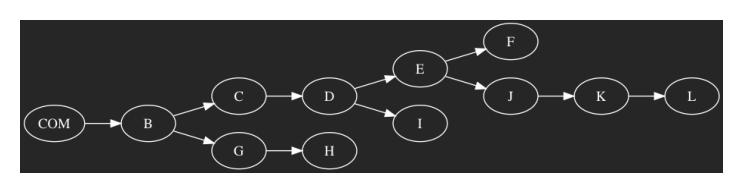

In [18]:
def make_graph_png(name, edges, graphtype='digraph', direction='LR'):
    """ Create graph spec name.dot and graph image name.png using graphviz """
    # command line : "dot -Tpng day6.dot > day6.png "
    filename = name + '.dot'
    with open(filename, 'w') as graphviz:
        graphviz.write(f'{graphtype} {{\n rankdir="{direction}"; \n')
        for (a,b) in edges:
            graphviz.write(f' "{a}" -> "{b}"; \n')
        graphviz.write('}\n')
    dot_command = f"dot -Tpng {filename} > {name}.png"
    dot_result = subprocess.run(dot_command, shell=True, 
                                stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if dot_result.returncode != 0:
        print(f"subprocess.run({dot_command})")
        print(f"  stdout: '{dot_result.stdout}'")
        print(f"  stdout: '{dot_result.stdout}'")
make_graph_png(name='day6', edges=day6)  # day6.png is too big to show here.
make_graph_png(name='day6_example', edges=example6)
show_png('day6_example.png')    

### Day 6 Part 1

In [35]:
def get_planet(name, planets):
    if not name in planets:
        planets[name] = {'name': name, 'orbits':0, 'parents':set(), 'children':set()}
    return planets[name]

def make_planets(orbits):
    planets = {}
    for (name_a, name_b) in orbits:
        a = get_planet(name_a, planets)
        b = get_planet(name_b, planets)
        a['children'].add(name_b)
        b['parents'].add(name_a)
    return planets

planets = make_planets(example)
        
print(f"Number of planets (graph nodes) is {len(planets)}.")    

print("Planets without a parent: ", end='')
for name in planets:
    if len(planets[name]['parents']) == 0:
        print(name+' ', end='')
print()

kidless=0
xtra_parent = 0
for name in planets:
    if len(planets[name]['children']) == 0:
        kidless += 1
    if len(planets[name]['parents']) > 1:
        xtra_parent += 1
print(f"Number without children: {kidless}.")
print(f"Number with more than one parent: {xtra_parent}.")

def assign_orbits(name, planets):
    print(name)
    if planets[name]['parents']:
        parent = tuple(planets[name]['parents'])[0]
        planets[name]['orbits'] = planets[parent]['orbits'] + 1
    else:
        planets[name]['orbits'] = 0
    for child in planets[name]['children']:
        assign_orbits(child, planets)

#assign_orbits('COM', planets)
#for name in planets:
#    print(name, planets[name]['orbits'])


Number of planets (graph nodes) is 12.
Planets without a parent: COM 
Number without children: 4.
Number with more than one parent: 0.


In [36]:
planets

{'COM': {'name': 'COM', 'orbits': 0, 'parents': set(), 'children': {'B'}},
 'B': {'name': 'B', 'orbits': 0, 'parents': {'COM'}, 'children': {'C', 'G'}},
 'C': {'name': 'C', 'orbits': 0, 'parents': {'B'}, 'children': {'D'}},
 'D': {'name': 'D', 'orbits': 0, 'parents': {'C'}, 'children': {'E', 'I'}},
 'E': {'name': 'E', 'orbits': 0, 'parents': {'D'}, 'children': {'F', 'J'}},
 'F': {'name': 'F', 'orbits': 0, 'parents': {'E'}, 'children': set()},
 'G': {'name': 'G', 'orbits': 0, 'parents': {'B'}, 'children': {'H'}},
 'H': {'name': 'H', 'orbits': 0, 'parents': {'G'}, 'children': set()},
 'I': {'name': 'I', 'orbits': 0, 'parents': {'D'}, 'children': set()},
 'J': {'name': 'J', 'orbits': 0, 'parents': {'E'}, 'children': {'K'}},
 'K': {'name': 'K', 'orbits': 0, 'parents': {'J'}, 'children': {'L'}},
 'L': {'name': 'L', 'orbits': 0, 'parents': {'K'}, 'children': set()}}

In [37]:
assign_orbits('COM', planets)

COM
B
G
H
C
D
I
E
J
K
L
F


In [38]:
planets

{'COM': {'name': 'COM', 'orbits': 0, 'parents': set(), 'children': {'B'}},
 'B': {'name': 'B', 'orbits': 1, 'parents': {'COM'}, 'children': {'C', 'G'}},
 'C': {'name': 'C', 'orbits': 2, 'parents': {'B'}, 'children': {'D'}},
 'D': {'name': 'D', 'orbits': 3, 'parents': {'C'}, 'children': {'E', 'I'}},
 'E': {'name': 'E', 'orbits': 4, 'parents': {'D'}, 'children': {'F', 'J'}},
 'F': {'name': 'F', 'orbits': 5, 'parents': {'E'}, 'children': set()},
 'G': {'name': 'G', 'orbits': 2, 'parents': {'B'}, 'children': {'H'}},
 'H': {'name': 'H', 'orbits': 3, 'parents': {'G'}, 'children': set()},
 'I': {'name': 'I', 'orbits': 4, 'parents': {'D'}, 'children': set()},
 'J': {'name': 'J', 'orbits': 5, 'parents': {'E'}, 'children': {'K'}},
 'K': {'name': 'K', 'orbits': 6, 'parents': {'J'}, 'children': {'L'}},
 'L': {'name': 'L', 'orbits': 7, 'parents': {'K'}, 'children': set()}}

In [39]:
sum(planets[name]['orbits'] for name in planets)

42

### Day 6 Part 2

----
## Explorations